# **Загрузка набора данных**

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# **Визуализация картинок из чисел**

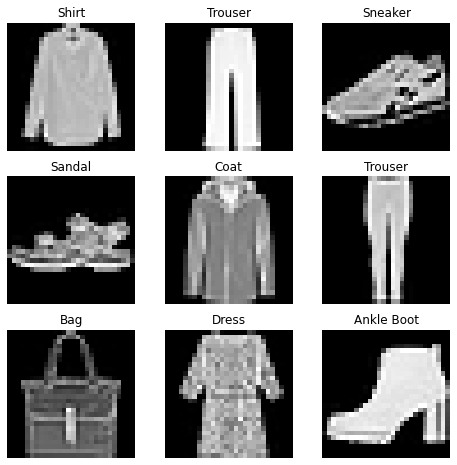

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # рэндомный номер картинка 1 из 60000
    img, label = training_data[sample_idx] # img - матрица картинки вытаскивается, label - метка
    figure.add_subplot(rows, cols, i) # вставляет картинку в зависимости от i
    plt.title(labels_map[label]) # доступ к названию предмета по метке
    plt.axis("off") # убирает оси
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

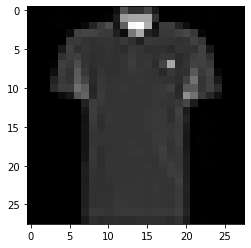

In [ ]:
plt.imshow(training_data[202][0].squeeze(), cmap="gray") # смотрим картинки

_________________________________________________________________________
**разъяснения:**

In [ ]:
print(torch.randint(len(training_data), size=(1,)))
print(torch.randint(len(training_data), size=(1,)).item())

tensor([5064])
37607


In [ ]:
torch.randint(len(training_data), size=(2,2))

tensor([[53228, 17455],
        [ 6307, 50305]])

In [ ]:
training_data[4] # комплект изображение + метка

In [ ]:
training_data[156][0].squeeze() # показывает матрицу изображения, снижая (.squeeze()) размерность до 2-х

In [ ]:
training_data[156][1] # смотрим метку

8

In [ ]:
img, label = training_data[50496] # img - матрица картинки вытаскивается, label - метка

In [ ]:
label

4

# **Создание пользовательского набора данных для ваших файлов**

изображения FashionMNIST хранятся в каталоге img_dir, а их ярлыки хранятся отдельно в файле CSV annotations_file

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# **Подготовка данных для обучения с помощью загрузчиков данных**

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# **Выполните итерацию через загрузчик данных**

**train_features, train_labels = next(iter(train_dataloader))** - попарно итерирует картинку и метку (разделяем набор картинок и набор меток)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


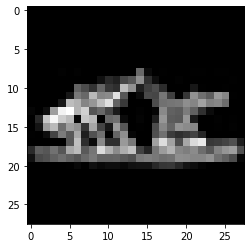

Label: 5


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader)) # попарно итерирует картинку и метку
                                                            #(разделяем набор картинок и набор меток)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

_________________________________________________________________________
**разъяснения:**

In [ ]:
train_labels

tensor([5, 3, 6, 8, 0, 5, 3, 2, 9, 1, 6, 4, 8, 7, 0, 0, 8, 3, 2, 4, 0, 3, 7, 0,
        1, 3, 7, 1, 2, 7, 8, 1, 8, 2, 5, 2, 9, 5, 1, 4, 7, 2, 1, 3, 2, 1, 5, 2,
        8, 6, 2, 4, 8, 7, 4, 9, 0, 9, 2, 4, 1, 7, 6, 2])

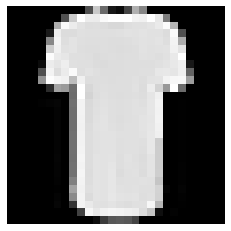

In [ ]:
plt.imshow(train_features[4].squeeze(), cmap="gray")
plt.axis("off")
plt.show()

# **ПОСТРОЕНИЕ НЕЙРОННОЙ СЕТИ**

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# **Получить устройство для обучения**

**Подключаем модуль CUDA**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# **Определите класс**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

**Мы создаем экземпляр NeuralNetwork, перемещаем его в device, и печатаем его структуру.**

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# **Предсказание:**

In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5], device='cuda:0')


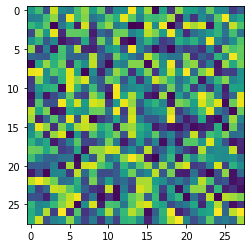

In [ ]:
plt.imshow(torch.rand(1, 28, 28).squeeze()) # это то, что пытаемся предсказать )))

# **Разъяснения слоев модели:**

**Матрица 2-го порядка c 3-мя матрицами, для разъяснения**

In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())
input_image

torch.Size([3, 28, 28])


tensor([[[0.1846, 0.0227, 0.2799,  ..., 0.2216, 0.2265, 0.5956],
         [0.9350, 0.3089, 0.6886,  ..., 0.3791, 0.9261, 0.4825],
         [0.2677, 0.0946, 0.3450,  ..., 0.9946, 0.0735, 0.0055],
         ...,
         [0.2200, 0.3947, 0.5437,  ..., 0.6555, 0.3457, 0.7372],
         [0.6764, 0.6745, 0.3837,  ..., 0.3439, 0.2464, 0.1121],
         [0.4039, 0.5910, 0.5803,  ..., 0.7570, 0.6194, 0.1078]],

        [[0.8555, 0.9145, 0.7339,  ..., 0.0464, 0.3514, 0.3077],
         [0.5257, 0.1228, 0.0274,  ..., 0.7625, 0.0791, 0.4784],
         [0.8155, 0.2610, 0.8637,  ..., 0.5163, 0.7047, 0.0266],
         ...,
         [0.8996, 0.8348, 0.8998,  ..., 0.3886, 0.9378, 0.3610],
         [0.8170, 0.0052, 0.8262,  ..., 0.6396, 0.1944, 0.2183],
         [0.8890, 0.6101, 0.5296,  ..., 0.9893, 0.8638, 0.3155]],

        [[0.5114, 0.2504, 0.2677,  ..., 0.4436, 0.6581, 0.9070],
         [0.4579, 0.3226, 0.9843,  ..., 0.6917, 0.3464, 0.0469],
         [0.3904, 0.9534, 0.4653,  ..., 0.3092, 0.7535, 0.

**nn.Flatten**

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print (flat_image.size())
flat_image

**nn.Linear**

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())
layer1

torch.Size([3, 20])


Linear(in_features=784, out_features=20, bias=True)

_________________________________________________________________________
**разъяснения:**

In [ ]:
# создает матрицу весов 4х5 (зависимая переменная) и вектор смещения (независимая переменная),
# решается линейное уравнение y = x*W^T + b и вроде через сигмойду пропускается +-1,
# аргумент - входные значения
m = nn.Linear(4,5)
m

Linear(in_features=4, out_features=5, bias=True)

In [ ]:
m.weight

Parameter containing:
tensor([[-0.3136, -0.2505,  0.2619,  0.4065],
        [ 0.4447,  0.3984,  0.3271,  0.0613],
        [-0.0932,  0.1953,  0.1114, -0.0029],
        [-0.0507,  0.1265, -0.1252,  0.0177],
        [ 0.3209,  0.3416, -0.2600,  0.4509]], requires_grad=True)

In [ ]:
m.bias

Parameter containing:
tensor([ 0.1648,  0.2035, -0.2593, -0.3818,  0.1799], requires_grad=True)

__________________________________________________

**nn.ReLU**

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.0203, -0.2737, -0.2405,  0.2856, -0.4874,  0.1680, -0.3207,  0.1895,
          0.2977,  0.2221,  0.1889,  0.4355, -0.4107,  0.2486,  0.3738,  0.5151,
          0.2092,  0.2742, -0.2397, -0.3244],
        [ 0.2417, -0.5059, -0.5311,  0.1827, -0.2451, -0.2342, -0.4568,  0.1696,
          0.1042,  0.2184, -0.0876,  0.2746,  0.3698,  0.4877,  0.2139,  0.4063,
          0.4259,  0.2932, -0.2269, -0.6407],
        [-0.1008, -0.5507, -0.5359,  0.2430, -0.0755,  0.3868, -0.2796,  0.1750,
          0.3921,  0.0993,  0.2894,  0.3223, -0.1165,  0.3072,  0.1632,  0.4271,
          0.2674,  0.1790, -0.3791, -0.6472]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.2856, 0.0000, 0.1680, 0.0000, 0.1895, 0.2977,
         0.2221, 0.1889, 0.4355, 0.0000, 0.2486, 0.3738, 0.5151, 0.2092, 0.2742,
         0.0000, 0.0000],
        [0.2417, 0.0000, 0.0000, 0.1827, 0.0000, 0.0000, 0.0000, 0.1696, 0.1042,
         0.2184, 0.0000, 0.2746, 0.3698, 0.4877, 0.21

**nn.Sequential**

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
logits

tensor([[-0.0724, -0.1575,  0.0664,  0.0897,  0.2065,  0.0180, -0.5017, -0.0242,
          0.0472,  0.4672],
        [-0.0532, -0.2372,  0.0555,  0.0705,  0.1506,  0.1316, -0.5407,  0.1109,
         -0.0358,  0.2253],
        [-0.1441, -0.1332,  0.0671, -0.0240,  0.1895, -0.0198, -0.3625,  0.0768,
          0.0770,  0.2048]], grad_fn=<AddmmBackward0>)

**nn.Softmax**

In [ ]:
softmax = nn.Softmax(dim = 1)
pred_probab = softmax(logits)
pred_probab

tensor([[0.0893, 0.0820, 0.1026, 0.1050, 0.1180, 0.0977, 0.0581, 0.0937, 0.1006,
         0.1531],
        [0.0940, 0.0782, 0.1048, 0.1064, 0.1152, 0.1131, 0.0577, 0.1108, 0.0956,
         0.1242],
        [0.0861, 0.0870, 0.1063, 0.0971, 0.1202, 0.0975, 0.0692, 0.1073, 0.1074,
         0.1220]], grad_fn=<SoftmaxBackward0>)

**Параметры модели:**

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0029,  0.0199,  0.0149,  ..., -0.0076,  0.0082, -0.0174],
        [ 0.0240,  0.0283,  0.0307,  ..., -0.0248,  0.0130,  0.0093]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0345, -0.0036], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0244, -0.0226, -0.0303,  ...,  0.0163,  0.0343, -0.0032],
        [-0.0056,  0.0222,  0.0030,  ..., -0.0337,  0.0005,  0.0374]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# **АВТОМАТИЧЕСКАЯ ДИФФЕРЕНЦИАЦИЯ С TORCH.AUTOGRAD**

In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
x,y,w,b,x,loss.item()

(tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 0.]),
 tensor([[-0.1183,  0.4812,  0.5550],
         [-0.8365,  0.0897,  0.1798],
         [ 1.9515, -0.5747, -1.6910],
         [ 1.1938,  1.3984, -0.4733],
         [-1.0063, -0.3348, -1.2871]], requires_grad=True),
 tensor([-0.8573, -1.0877, -1.0545], requires_grad=True),
 tensor([1., 1., 1., 1., 1.]),
 0.5239996314048767)

In [ ]:
loss.item()

0.5239996314048767

# **Тензоры, функции и вычислительный граф**

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f7964bbac10>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f7964bbaed0>


# **Вычисление градиентов**

Чтобы оптимизировать веса параметров в нейронной сети, нам нужно вычислить производные нашей функции потерь по параметрам, а именно, нам нужны \frac{\partial loss}{\partial w}
∂w
∂l oss
  и \frac{\partial loss}{\partial b}
∂b
∂l oss
  при некоторых фиксированных значениях xи y. Чтобы вычислить эти производные, мы вызываемloss.backward(), а затем извлекаем значения из w.gradиb.grad:

смотри https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2748, 0.2839, 0.3072],
        [0.2748, 0.2839, 0.3072],
        [0.2748, 0.2839, 0.3072],
        [0.2748, 0.2839, 0.3072],
        [0.2748, 0.2839, 0.3072]])
tensor([0.2748, 0.2839, 0.3072])


# **Отключение отслеживания градиента**

**1-й способ**

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


**2-й способ**

In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


# **ОПТИМИЗАЦИЯ ПАРАМЕТРОВ МОДЕЛИ**

# **Обязательный код**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

# **Дополнительное чтение: тензорные градиенты и произведения Якоби**

In [ ]:
inp=torch.eye(4, 5, requires_grad=True)
out=(inp+1).pow(2).t()
out

tensor([[4., 1., 1., 1.],
        [1., 4., 1., 1.],
        [1., 1., 4., 1.],
        [1., 1., 1., 4.],
        [1., 1., 1., 1.]], grad_fn=<TBackward0>)

In [ ]:
torch.ones_like(out)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [ ]:
out.backward(torch.ones_like(out), retain_graph=True)

In [ ]:
inp.grad

tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


# **Гиперпараметры**

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

# **Цикл оптимизации**

In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# **Оптимизатор**

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# **Полная реализация**

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
enumerate(train_dataloader.dataset)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303427  [    0/60000]
loss: 2.294185  [ 6400/60000]
loss: 2.283306  [12800/60000]
loss: 2.281470  [19200/60000]
loss: 2.248290  [25600/60000]
loss: 2.228171  [32000/60000]
loss: 2.230286  [38400/60000]
loss: 2.199241  [44800/60000]
loss: 2.196887  [51200/60000]
loss: 2.165648  [57600/60000]
Test Error: 
 Accuracy: 42.8%, Avg loss: 2.164077 

Epoch 2
-------------------------------
loss: 2.164654  [    0/60000]
loss: 2.162005  [ 6400/60000]
loss: 2.112016  [12800/60000]
loss: 2.131830  [19200/60000]
loss: 2.068114  [25600/60000]
loss: 2.013877  [32000/60000]
loss: 2.039639  [38400/60000]
loss: 1.959815  [44800/60000]
loss: 1.964820  [51200/60000]
loss: 1.895270  [57600/60000]
Test Error: 
 Accuracy: 50.2%, Avg loss: 1.898508 

Epoch 3
-------------------------------
loss: 1.920171  [    0/60000]
loss: 1.901477  [ 6400/60000]
loss: 1.791493  [12800/60000]
loss: 1.836136  [19200/60000]
loss: 1.711557  [25600/60000]
loss: 1.667054  [32000/600

# **СОХРАНИТЕ И ЗАГРУЗИТЕ МОДЕЛЬ**

In [ ]:
import torch
import torchvision.models as models

# **Сохранение и загрузка весов модели**

In [ ]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
model = models.vgg16() # # мы не указываем pretrained=True, т.е. Не загружаем веса по умолчанию
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

# **Сохранение и загрузка моделей с формами**

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth')